In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn2

from datasets import (load_all_orfs,
                      load_I3D_exp_20,
                      load_y2h_prs_rrs_data,
                      load_GPCA_and_MAPPIT_data,
                      )
from alphafold_multimer_utils import (read_ipae, 
                                      read_iptm_plus_ptm,
                                      load_alphafold_residue_contacts,
                                      read_pdockq)
from plotting import (validation_plot, 
                      checkerboard, 
                      COLOR_PRS, 
                      COLOR_RRS)
from utils import has_interolog_structure_yeast

In [ ]:
in_dirs = [Path('../data/alphafold/scRRSv2/'), Path('../data/alphafold/scPRSv2/')]
dfs = []
for in_dir in in_dirs:
    data = []
    for fpath in in_dir.glob('*/ranked_0_contact_probability.txt'):
        with open(fpath, 'r') as f:
            data.append((fpath.parents[0].stem, float(f.read())))
    df = pd.DataFrame(data=data, columns=['pair', 'contact_probability'])
    df = pd.merge(df,
                read_pdockq(in_dir),
                on=['pair'],
                how='left')
    df = pd.merge(df,
                read_ipae(in_dir),
                on=['pair'],
                how='left')
    df = pd.merge(df,
                read_iptm_plus_ptm(in_dir),
                on=['pair'],
                how='left')
    full_table, summary_table = load_alphafold_residue_contacts(in_dir)
    for pae_cutoff in [4, 3, 2]:
        n_conf_rrc = full_table.loc[full_table['PAE'] <= pae_cutoff, :].groupby('pair').size()
        df[f'# residue contacts PAE ≤ {pae_cutoff} Å'] = df['pair'].map(n_conf_rrc).fillna(0)
    df['source'] = in_dir.stem
    dfs.append(df.copy())
df = pd.concat(dfs)

df['orf_name_a'] = df['pair'].apply(lambda x: x.split('_')[0])
df['orf_name_b'] = df['pair'].apply(lambda x: x.split('_')[1])
orfs = load_all_orfs()
df['gene_name_a'] = df['orf_name_a'].map(orfs.set_index('orf_name')['gene_name'])
df['gene_name_b'] = df['orf_name_b'].map(orfs.set_index('orf_name')['gene_name'])
df['gene_name_a'] = df['gene_name_a'].fillna(df['orf_name_a'])
df['gene_name_b'] = df['gene_name_b'].fillna(df['orf_name_b'])
df['is_homodimer'] = (df['orf_name_a'] == df['orf_name_b'])
df = df.loc[~df['is_homodimer'], :].drop(columns=['is_homodimer'])  # 
i3d = load_I3D_exp_20(remove_homodimers=False)
df['in_I3D-exp-20'] = df['pair'].isin(i3d.index)
df['has_interolog_structure'] = has_interolog_structure_yeast(df)
df = df.reset_index(drop=True)
no_structure = ~(df['in_I3D-exp-20'] | df['has_interolog_structure'])
is_prs = (df['source'] == 'scPRSv2')
df['is_PRS'] = (df['source'] == 'scPRSv2')

af3_dir = Path('../data/alphafold/AF3_scPRSv2_scRRSv2')
af3_results = []
for subdir in af3_dir.iterdir():
    if not subdir.stem.startswith('fold_'):
        continue
    with open(subdir / (subdir.stem + '_job_request.json'), 'r') as f:
        pair = json.load(f)[0]["name"]
    with open(subdir / (subdir.stem + '_summary_confidences_0.json'), 'r') as f:
        conf_scores = json.load(f)
        iptm = conf_scores["iptm"]
        ptm = conf_scores["ptm"]
    af3_results.append({'pair': pair, 'AF3_iPTM': iptm, 'AF3_PTM': ptm})
af3_results = pd.DataFrame(af3_results)
af3_results['AF3_iPTM+PTM'] = 0.8 * af3_results['AF3_iPTM'] + 0.2 * af3_results['AF3_PTM']
df = pd.merge(df, af3_results, how='left', on=['pair'])
df['AF2_iPTM+PTM'] = df['iPTM+PTM']

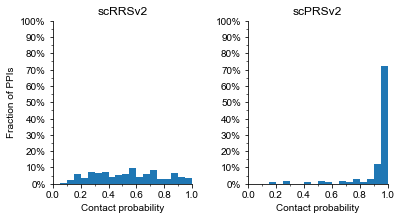

In [3]:
a = df.loc[df['source'] == 'scRRSv2', 'contact_probability'].values
b = df.loc[df['source'] == 'scPRSv2', 'contact_probability'].values
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=6, h=3)
axs[0].hist(a, range=(0, 1), bins=20)
axs[1].hist(b, range=(0, 1), bins=20)
axs[0].set_ylim(0, len(a))
axs[1].set_ylim(0, len(b))
axs[0].set_yticks([x * len(a) for x in np.arange(0, 1.01, 0.10)])
axs[0].set_yticks([x * len(a) for x in np.arange(0, 1.01, 0.05)], minor=True)
axs[0].set_yticklabels(['{:.0%}'.format((y / len(a))) for y in axs[0].get_yticks()])
axs[1].set_yticks([x * len(b) for x in np.arange(0, 1.01, 0.1)])
axs[1].set_yticks([x * len(b) for x in np.arange(0, 1.01, 0.05)], minor=True)
axs[1].set_yticklabels(['{:.0%}'.format((y / len(b))) for y in axs[1].get_yticks()])
for ax in axs:
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.01, 0.2))
    ax.set_xticks(np.arange(0, 1.01, 0.1), minor=True)
    ax.set_xlabel('Contact probability')
axs[0].set_ylabel('Fraction of PPIs')
axs[0].set_title('scRRSv2')
axs[1].set_title('scPRSv2')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/contact_probability_PRS_RRS_hist.pdf',
            bbox_inches='tight')

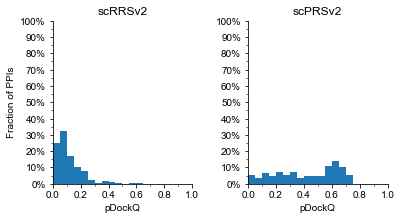

In [4]:
a = df.loc[df['source'] == 'scRRSv2', 'pDockQ'].values
b = df.loc[df['source'] == 'scPRSv2', 'pDockQ'].values
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=6, h=3)
axs[0].hist(a, range=(0, 1), bins=20)
axs[1].hist(b, range=(0, 1), bins=20)
axs[0].set_ylim(0, len(a))
axs[1].set_ylim(0, len(b))
axs[0].set_yticks([x * len(a) for x in np.arange(0, 1.01, 0.10)])
axs[0].set_yticks([x * len(a) for x in np.arange(0, 1.01, 0.05)], minor=True)
axs[0].set_yticklabels(['{:.0%}'.format((y / len(a))) for y in axs[0].get_yticks()])
axs[1].set_yticks([x * len(b) for x in np.arange(0, 1.01, 0.1)])
axs[1].set_yticks([x * len(b) for x in np.arange(0, 1.01, 0.05)], minor=True)
axs[1].set_yticklabels(['{:.0%}'.format((y / len(b))) for y in axs[1].get_yticks()])
for ax in axs:
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.01, 0.2))
    ax.set_xticks(np.arange(0, 1.01, 0.1), minor=True)
    ax.set_xlabel('pDockQ')
axs[0].set_ylabel('Fraction of PPIs')
axs[0].set_title('scRRSv2')
axs[1].set_title('scPRSv2')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/pDockQ_PRS_RRS_hist.pdf',
            bbox_inches='tight')

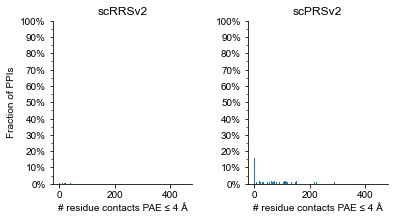

In [5]:
a = df.loc[df['source'] == 'scRRSv2', '# residue contacts PAE ≤ 4 Å'].values
b = df.loc[df['source'] == 'scPRSv2', '# residue contacts PAE ≤ 4 Å'].values
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=6, h=3)
x_max = int(df['# residue contacts PAE ≤ 4 Å'].max())
axs[0].hist(a, range=(-0.5, x_max + 0.5), bins=x_max + 1)
axs[1].hist(b, range=(-0.5, x_max + 0.5), bins=x_max + 1)
axs[0].set_ylim(0, len(a))
axs[1].set_ylim(0, len(b))
axs[0].set_yticks([x * len(a) for x in np.arange(0, 1.01, 0.10)])
axs[0].set_yticks([x * len(a) for x in np.arange(0, 1.01, 0.05)], minor=True)
axs[0].set_yticklabels(['{:.0%}'.format((y / len(a))) for y in axs[0].get_yticks()])
axs[1].set_yticks([x * len(b) for x in np.arange(0, 1.01, 0.1)])
axs[1].set_yticks([x * len(b) for x in np.arange(0, 1.01, 0.05)], minor=True)
axs[1].set_yticklabels(['{:.0%}'.format((y / len(b))) for y in axs[1].get_yticks()])
for ax in axs:
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
    #ax.set_xlim(0, 1)
    #ax.set_xticks(np.arange(0, 1.01, 0.2))
    #ax.set_xticks(np.arange(0, 1.01, 0.1), minor=True)
    ax.set_xlabel('# residue contacts PAE ≤ 4 Å')
axs[0].set_ylabel('Fraction of PPIs')
axs[0].set_title('scRRSv2')
axs[1].set_title('scPRSv2')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/n_residue_contacts_lt_pae_4A_PRS_RRS_hist.pdf',
            bbox_inches='tight')

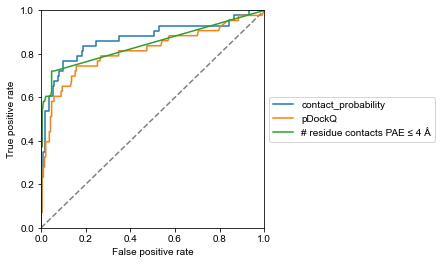

In [6]:
df['is_PRS'] = (df['source'] == 'scPRSv2')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.plot([0, 1], [0, 1], '--', color='grey')

var = 'contact_probability'
for var in ['contact_probability', 'pDockQ', '# residue contacts PAE ≤ 4 Å']:
    x, y = [], []
    target = df.loc[no_structure & df[var].notnull(), 'is_PRS']
    for cutoff in sorted(df[var].values):
        p = (df.loc[no_structure, var] >= cutoff)
        tp = target[p].sum()
        fp = (~target[p]).sum()
        tn = (~target[~p]).sum()
        fn = target[~p].sum()
        y.append(tp / (tp + fn))
        x.append(1 - (tn / (tn + fp)))
    ax.plot(x, y, label=var)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
fig.savefig('../figures/ROC_PRS_RRS_structures-removed.pdf', bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/1093584508.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/1093584508.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])


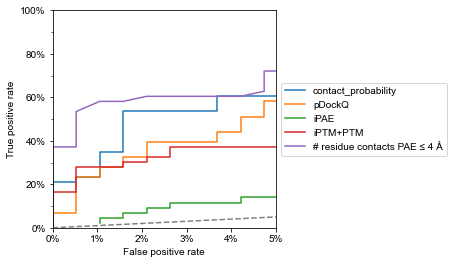

In [7]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.plot([0, 1], [0, 1], '--', color='grey')

var = 'contact_probability'
for var in ['contact_probability', 
            'pDockQ', 
            'iPAE',
            'iPTM+PTM',
            '# residue contacts PAE ≤ 4 Å',
            ]:
    x, y = [], []
    target = df.loc[no_structure & df[var].notnull(), 'is_PRS']
    for cutoff in sorted(df[var].values):
        p = (df.loc[no_structure, var] >= cutoff)
        tp = target[p].sum()
        fp = (~target[p]).sum()
        tn = (~target[~p]).sum()
        fn = target[~p].sum()
        y.append(tp / (tp + fn))
        x.append(1 - (tn / (tn + fp)))
    ax.plot(x, y, label=var)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_xlim(0, 0.05)
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
fig.savefig('../figures/ROC_PRS_RRS_structures-removed_all-metrics_zoom.pdf', bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/1599092212.py:20: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


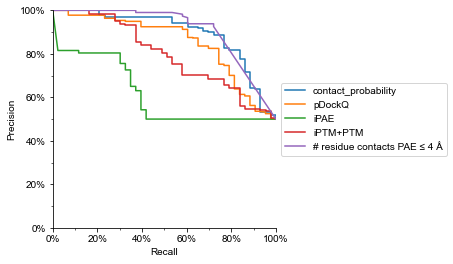

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)

prior = df.loc[no_structure, 'is_PRS'].sum() / no_structure.sum()
for var in ['contact_probability', 
            'pDockQ', 
            'iPAE',
            'iPTM+PTM',
            '# residue contacts PAE ≤ 4 Å',
            ]:
    x, y = [], []
    target = df.loc[no_structure & df[var].notnull(), 'is_PRS']
    for cutoff in sorted(df[var].values):
        p = (df.loc[no_structure, var] >= cutoff)
        tp = target[p].sum()
        fp = (~target[p]).sum()
        tn = (~target[~p]).sum()
        fn = target[~p].sum()
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        balanced_precision = (precision * (1. - prior)) / (precision * (1 - prior) + (1 - precision) * prior)
        x.append(recall)
        if len(y) == 0 or balanced_precision >= y[-1]:
            y.append(balanced_precision)
        else:
            y.append(y[-1])
    x.append(0)
    y.append(1)
    ax.plot(x, y, label=var)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
#ax.set_xlim(0, 0.05)
ax.set_xticks(np.linspace(0, 1, 6),)
ax.set_xticks(np.linspace(0, 1, 11), minor=True)
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(0, 1, 6),)
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('../figures/Precision-recall_balanced-monotonized_PRS_RRS_structures-removed_all-metrics.pdf', bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/2544485029.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/2544485029.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])


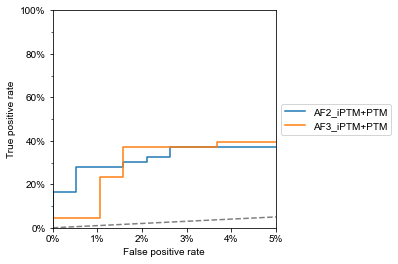

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.plot([0, 1], [0, 1], '--', color='grey')

vars = ['AF2_iPTM+PTM', 'AF3_iPTM+PTM']
for var in vars:
    x, y = [], []
    target = df.loc[no_structure & df[vars].notnull().all(axis=1), 'is_PRS']
    for cutoff in sorted(df[var].dropna().values):
        p = (df.loc[no_structure, var] >= cutoff)
        tp = target[p].sum()
        fp = (~target[p]).sum()
        tn = (~target[~p]).sum()
        fn = target[~p].sum()
        y.append(tp / (tp + fn))
        x.append(1 - (tn / (tn + fp)))
    ax.plot(x, y, label=var)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_xlim(0, 0.05)
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
fig.savefig('../figures/ROC_PRS_RRS_AF2vs3_structures-removed_zoom.pdf', bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/924615757.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/924615757.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])


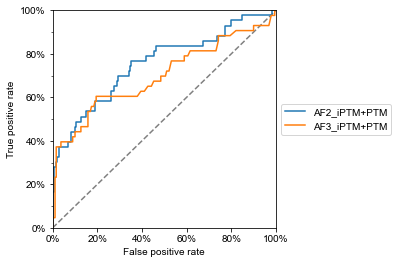

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
ax.plot([0, 1], [0, 1], '--', color='grey')

vars = ['AF2_iPTM+PTM', 'AF3_iPTM+PTM']
for var in vars:
    x, y = [], []
    target = df.loc[no_structure & df[vars].notnull().all(axis=1), 'is_PRS']
    for cutoff in sorted(df[var].dropna().values):
        p = (df.loc[no_structure, var] >= cutoff)
        tp = target[p].sum()
        fp = (~target[p]).sum()
        tn = (~target[~p]).sum()
        fn = target[~p].sum()
        y.append(tp / (tp + fn))
        x.append(1 - (tn / (tn + fp)))
    ax.plot(x, y, label=var)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel('True positive rate')
ax.set_xlabel('False positive rate')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
fig.savefig('../figures/ROC_PRS_RRS_AF2vs3_structures-removed.pdf', bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_15597/2597134364.py:17: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


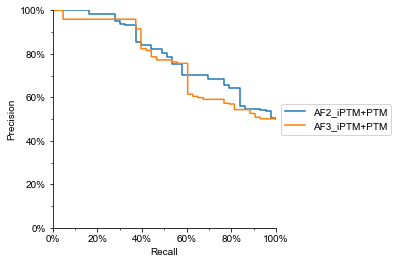

In [11]:
df['is_PRS'] = (df['source'] == 'scPRSv2')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.plot([0, 1], [0, 1], '--', color='grey')

prior = df.loc[no_structure, 'is_PRS'].sum() / no_structure.sum()
for var in ['AF2_iPTM+PTM', 'AF3_iPTM+PTM']:
    x, y = [], []
    target = df.loc[no_structure & df[var].notnull(), 'is_PRS']
    for cutoff in sorted(df.loc[df[var].notnull(), var].values):
        p = (df.loc[no_structure, var] >= cutoff)
        tp = target[p].sum()
        fp = (~target[p]).sum()
        tn = (~target[~p]).sum()
        fn = target[~p].sum()
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        balanced_precision = (precision * (1. - prior)) / (precision * (1 - prior) + (1 - precision) * prior)
        x.append(recall)
        if len(y) == 0 or balanced_precision >= y[-1]:
            y.append(balanced_precision)
        else:
            y.append(y[-1])
    x.append(0)
    y.append(1)
    ax.plot(x, y, label=var)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
#ax.set_xlim(0, 0.05)
ax.set_xticks(np.linspace(0, 1, 6),)
ax.set_xticks(np.linspace(0, 1, 11), minor=True)
ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
ax.set_yticks(np.linspace(0, 1, 6),)
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('../figures/Precision-recall_balanced-monotonized_PRS_RRS_AF2vs3_structures-removed.pdf', bbox_inches='tight')

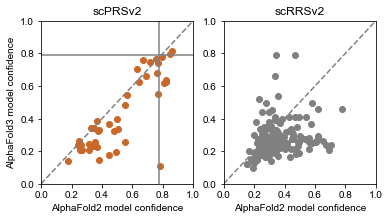

In [12]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(w=6, h=3)
valid_pairs = (no_structure
               & df['AF2_iPTM+PTM'].notnull() 
               & df['AF3_iPTM+PTM'].notnull())
af2_prs = df.loc[valid_pairs & (df['source'] == 'scPRSv2'), 'AF2_iPTM+PTM'].values
af3_prs = df.loc[valid_pairs & (df['source'] == 'scPRSv2'), 'AF3_iPTM+PTM'].values
af2_rrs = df.loc[valid_pairs & (df['source'] == 'scRRSv2'), 'AF2_iPTM+PTM'].values
af3_rrs = df.loc[valid_pairs & (df['source'] == 'scRRSv2'), 'AF3_iPTM+PTM'].values
axs[0].scatter(x=af2_prs, y=af3_prs, color=COLOR_PRS)
axs[1].scatter(x=af2_rrs, y=af3_rrs, color=COLOR_RRS)

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_xlabel('AlphaFold2 model confidence')
axs[0].set_title('scPRSv2')
axs[1].set_title('scRRSv2')
axs[0].set_ylabel('AlphaFold3 model confidence')
axs[0].axhline(y=af3_rrs.max(), color=COLOR_RRS)
axs[0].axvline(x=af2_rrs.max(), color=COLOR_RRS)
fig.savefig('../figures/AF2vs3_PRS_RRS_structures-removed_scatter.pdf', bbox_inches='tight')

In [13]:
def make_checkerboard(data, experiments_to_plot, name, dataset='PRS', **kwargs):
    
    if dataset not in ('PRS', 'RRS'):
        raise ValueError('Must be PRS or RRS')
    
    if 'orientation' in data.columns:
        prs_data = (data.loc[data['source_dataset'] == 'sc' + dataset + 'v2', :]
                        .pivot(index='pair_gene_names',
                               columns='orientation',
                               values=['r02 v1', 'r02 v4', 'S07']))
        prs_data.columns = [c[1] + ' ' + c[0] for c in prs_data.columns]
        prs_data['gene_name_X'] = prs_data.index.map(lambda x: x.split(' ')[0]).values
        prs_data['gene_name_Y'] = prs_data.index.map(lambda x: x.split(' ')[1]).values
    else:
        prs_data = data.loc[data['source_dataset'] == 'sc' + dataset + 'v2', :].copy()
    n_rrs_pairs = data.loc[data['source_dataset'] == 'scRRSv2', 'pair_gene_names'].nunique()

    color_for_scores = {'Positive': COLOR_PRS, 
                        'Negative': 'white',
                         'Test failed': 'grey', 
                        'Autoactivator': 'teal', 
                        'Failed sequence confirmation': 'blue'
                   }

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18 * (prs_data.shape[0] / n_rrs_pairs), 0.4 + 0.05 * len(experiments_to_plot))
    pairs_order = checkerboard(prs_data, 
                               protein_a_column='gene_name_X', 
                               protein_b_column='gene_name_Y',
                               detection_columns=experiments_to_plot,
                               colors=color_for_scores,
                               draw_box=True,
                               draw_gene_names=True,
                               draw_grid=True,
                               grid_color='grey',
                               ax=ax,
                               **kwargs)
    ax.legend(handles=[Patch(facecolor=color, edgecolor='grey', label=label) 
                       for label, color in color_for_scores.items()
                       if label in set(prs_data[experiments_to_plot].values.flatten())],
              loc='center left', bbox_to_anchor=[1., 0.5])
        
    plt.savefig('../figures/{}_checkerboard_Y2H_{}.pdf'.format(dataset, name), bbox_inches='tight')
    return pairs_order


def one_score_per_pair(scores):
    """Collapse the scores for the two orientations to a single score"""
    #print(scores)
    #raise UserWarning()
    if len(scores) == 1:
        return scores.iloc[0]
    elif len(scores) > 2:
        raise UserWarning('Should only have two orientations')
        
    if (scores == 'Positive').any():
        return 'Positive'
    elif (scores == 'Negative').any() or (scores == 'Autoactivator').any():
        return 'Negative'
    else:
        return 'Test failed'


prsrrs = load_y2h_prs_rrs_data()
perpair = (prsrrs.groupby('pair_gene_names')
            .aggregate({'orf_name_X': lambda x: x.iloc[0],
                        'orf_name_Y': lambda x: x.iloc[0],
                        'gene_name_X': lambda x: x.iloc[0],
                        'gene_name_Y': lambda x: x.iloc[0],
                        'source_dataset': lambda x: x.iloc[0],
                        'S07': one_score_per_pair,
                        'r02 v1': one_score_per_pair,
                        'r02 v4': one_score_per_pair})
           .reset_index())

val = load_GPCA_and_MAPPIT_data(remove_homodimers=False)
mappit = val.loc[(val['experiment_ID'] == 'Sv03') &
                  val['source_dataset'].isin(['scPRS-v2', 'scRRS-v2']), :]
gpca = val.loc[(val['experiment_ID'] == 'Sv01') &
                  val['source_dataset'].isin(['scPRS-v2', 'scRRS-v2']), :]
perpair['pair'] = perpair[['orf_name_X', 'orf_name_Y']].min(axis=1) + '_' + perpair[['orf_name_X', 'orf_name_Y']].max(axis=1)
if mappit['pair'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
if gpca['pair'].duplicated().any():
    raise UserWarning('Unexpected duplicates')
perpair['MAPPIT'] = perpair['pair'].map(mappit.set_index('pair')['result_at_0_RRS'])
perpair['MAPPIT'] = perpair['MAPPIT'].map({True: 'Positive', False: 'Negative', np.nan: 'Test failed'})
perpair['GPCA'] = perpair['pair'].map(gpca.set_index('pair')['result_at_0_RRS'])
perpair['GPCA'] = perpair['GPCA'].map({True: 'Positive', False: 'Negative', np.nan: 'Test failed'})

perpair = perpair.rename(columns={'r02 v1': 'Y2H v1', 'r02 v4': 'Y2H v4'})

perpair['AlphaFold > 40 confident contacts'] = perpair['pair'].map((
                        df.set_index('pair')
                        ['# residue contacts PAE ≤ 4 Å'] > 40)
                        .map({False: 'Negative', True: 'Positive'})
                        )
for c in perpair.columns:
    if c.startswith('AlphaFold'):
        perpair[c] = perpair[c].fillna('Test failed')

perpair['in_I3D-exp-20'] = perpair['pair'].isin(i3d.index)
perpair['has_interolog_structure'] = has_interolog_structure_yeast(perpair, col_a='orf_name_X', col_b='orf_name_Y')


perpair['Assayome'] = (
                        (perpair['Y2H v1'] == 'Positive') 
                       | (perpair['Y2H v4'] == 'Positive') 
                       | (perpair['MAPPIT'] == 'Positive') 
                       | (perpair['GPCA'] == 'Positive') 
                       ).map({True: 'Positive', False: 'Negative'})
perpair['Union'] = (
                        (perpair['Assayome'] == 'Positive') 
                       | (perpair['AlphaFold > 40 confident contacts'] == 'Positive')  
                       ).map({True: 'Positive', False: 'Negative'})

# HACK used to add some dividing rows in checkerboard plot
perpair[''] = 'Negative'


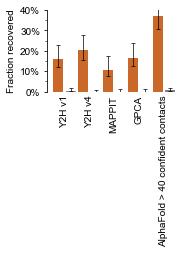

In [14]:
fig, ax = plt.subplots(ncols=1, nrows=1, sharey=True)
fig.set_size_inches(w=2.4, h=1.5)

assays = ['Y2H v1', 'Y2H v4', 'MAPPIT', 'GPCA', 'AlphaFold > 40 confident contacts']
no_prev_struct = (~perpair['in_I3D-exp-20'] 
                  & ~perpair['has_interolog_structure'])

pos = [(no_prev_struct & (perpair['source_dataset'] == ds) & (perpair[assay_name] == 'Positive')).sum() for assay_name in assays for ds in ['scPRSv2', 'scRRSv2']]
ns = [(no_prev_struct & (perpair['source_dataset'] == ds) & (perpair[assay_name] != 'Test failed')).sum() for assay_name in assays for ds in ['scPRSv2', 'scRRSv2']]
validation_plot(
    positives=pos,
    n_tested=ns,
    ax=ax,
    y_max=0.4,
    labels=['PRS', 'RRS'] * len(assays),
    draw_numbers=False,
    colors=[COLOR_PRS, COLOR_RRS] * len(assays),
    xlabel_rotation=90,
    errorbar_capsize=0.5,
    errorbar_thickness=0.7,
)
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_facecolor('white')
ax.set_ylabel('Fraction recovered')
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
ax.set_xticks(np.linspace(0.5, 8.5, 5))
ax.set_xticklabels(assays)
fig.savefig('../figures/PRS_RRS-with-AF_bar.pdf',
            bbox_inches='tight')

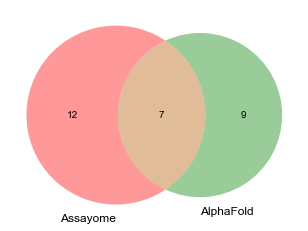

In [15]:
# venn vs assays
assays = ['Assayome', 'AlphaFold > 40 confident contacts']
positives = {}
for assay_name in assays:
    positives[assay_name] = set(perpair.loc[(perpair['source_dataset'] == 'scPRSv2')
                & no_prev_struct
                & ~(perpair[assays] == 'Test failed').any(axis=1)
                & (perpair[assay_name] == 'Positive'),
            'pair_gene_names'].values)
venn2(positives.values(), 
      set_labels=('Assayome', 'AlphaFold'),
      )
plt.savefig('../figures/PRS-poistives_assayome-AF-_Venn.pdf',
            bbox_inches='tight')

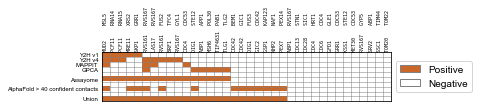

In [16]:
assays = ['Y2H v1',
          'Y2H v4',
          'MAPPIT',
          'GPCA',
          '',
          'Assayome',
          '',
          'AlphaFold > 40 confident contacts',
        '',
        'Union',
          ]
__ = make_checkerboard(perpair.loc[(perpair[assays] != 'Test failed').all(axis=1)
                                   & ~perpair['in_I3D-exp-20']
                                   & ~perpair['has_interolog_structure'],
                                   :],
                       assays,
                      'AlphaFold',
                       'PRS',
                       alternative_sort=True)

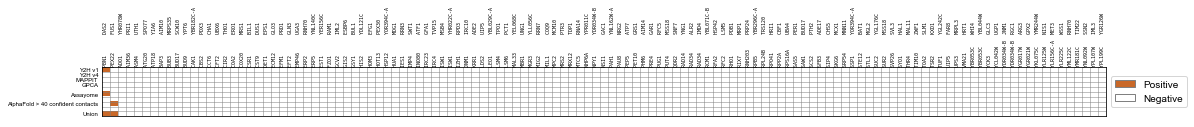

In [17]:
assays = ['Y2H v1',
          'Y2H v4',
          'MAPPIT',
          'GPCA',
          '',
          'Assayome',
          '',
          'AlphaFold > 40 confident contacts',
        '',
        'Union',
          ]
__ = make_checkerboard(perpair.loc[(perpair[assays] != 'Test failed').all(axis=1)
                                   & ~perpair['in_I3D-exp-20']
                                   & ~perpair['has_interolog_structure'],
                                   :],
                       assays,
                      'AlphaFold',
                       'RRS',
                       alternative_sort=True)